In [29]:
#IMPORTING SOME LIBRARY

import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import json
import requests

from datetime import datetime, date, timedelta

In [30]:
#Config chart

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [37]:
stock = "ETHUSDT"
url = f"https://api.binance.com/api/v3/klines?symbol={stock}&interval=1m"
r = requests.get(url)
klines = np.array(r.json())
klines

array([['1619401260000', '2444.33000000', '2452.73000000', ...,
        '2483.46183000', '6081274.04289190', '0'],
       ['1619401320000', '2451.21000000', '2452.52000000', ...,
        '958.26714000', '2344999.14242450', '0'],
       ['1619401380000', '2443.06000000', '2449.66000000', ...,
        '796.92056000', '1949113.46613060', '0'],
       ...,
       ['1619431080000', '2478.05000000', '2480.00000000', ...,
        '343.03625000', '850301.91387450', '0'],
       ['1619431140000', '2478.72000000', '2484.14000000', ...,
        '655.05516000', '1625278.08608310', '0'],
       ['1619431200000', '2483.38000000', '2483.78000000', ...,
        '124.07370000', '308044.14787000', '0']], dtype='<U21')

In [38]:
def binance_to_df(klines):
    df = pd.DataFrame(klines.reshape(-1,12),dtype=float, columns = ('t',
                                                                    'o',
                                                                    'h',
                                                                    'l',
                                                                    'c',
                                                                    'v',
                                                                    'Close time',
                                                                    'Quote asset volume',
                                                                    'Number of trades',
                                                                    'Taker buy base asset volume',
                                                                    'Taker buy quote asset volume',
                                                                    'Ignore'))

    df['t'] = pd.to_datetime(df['t'], unit='ms')


    return df

prices = binance_to_df(klines)
prices.head()

,t,o,h,l,c,v,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-04-26 01:41:00,2444.33,2452.73,2443.09,2451.20,3210.70997,1.619401e+12,7.862197e+06,4235.0,2483.46183,6.081274e+06,0.0
1,2021-04-26 01:42:00,2451.21,2452.52,2441.72,2442.59,1791.75224,1.619401e+12,4.383918e+06,2851.0,958.26714,2.344999e+06,0.0
2,2021-04-26 01:43:00,2443.06,2449.66,2442.99,2449.59,1538.07856,1.619401e+12,3.761725e+06,2076.0,796.92056,1.949113e+06,0.0
3,2021-04-26 01:44:00,2449.67,2449.95,2437.56,2440.52,4896.05078,1.619401e+12,1.195655e+07,2954.0,3101.34964,7.570923e+06,0.0
4,2021-04-26 01:45:00,2440.71,2447.91,2438.76,2445.23,2125.43105,1.619402e+12,5.188492e+06,1942.0,1484.38716,3.622438e+06,0.0


In [39]:
def resample(data, rate):
    data = data.resample(rate, on='t',closed='right', label='right').agg({'o': 'first',
                                                                                                 'h': 'max',
                                                                                                 'l': 'min',
                                                                                                 'c': 'last'}).dropna()
    return data
resampled_prices = resample(prices, '1T')
resampled_prices


,o,h,l,c
t,,,,
2021-04-26 01:41:00,2444.33,2452.73,2443.09,2451.20
2021-04-26 01:42:00,2451.21,2452.52,2441.72,2442.59
2021-04-26 01:43:00,2443.06,2449.66,2442.99,2449.59
2021-04-26 01:44:00,2449.67,2449.95,2437.56,2440.52
2021-04-26 01:45:00,2440.71,2447.91,2438.76,2445.23
...,...,...,...,...
2021-04-26 09:56:00,2479.70,2481.89,2477.91,2478.86
2021-04-26 09:57:00,2478.86,2479.00,2475.00,2478.05
2021-04-26 09:58:00,2478.05,2480.00,2476.89,2478.73


In [40]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['c'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['c'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['c'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['t'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['c']
    return max_min

min_max = get_max_min(resampled_prices, 3, 3)
min_max



day_num
6      2433.47
7      2434.99
9      2454.53
15     2453.87
18     2446.95
        ...   
468    2425.77
476    2438.39
477    2443.03
493    2484.30
496    2478.05
Name: c, Length: 118, dtype: float64

In [41]:
def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   

        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
              patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns
patterns = find_patterns(min_max)
print(patterns['IHS'])

[(88, 102), (126, 143), (143, 158), (198, 218), (242, 262), (311, 329), (383, 399)]


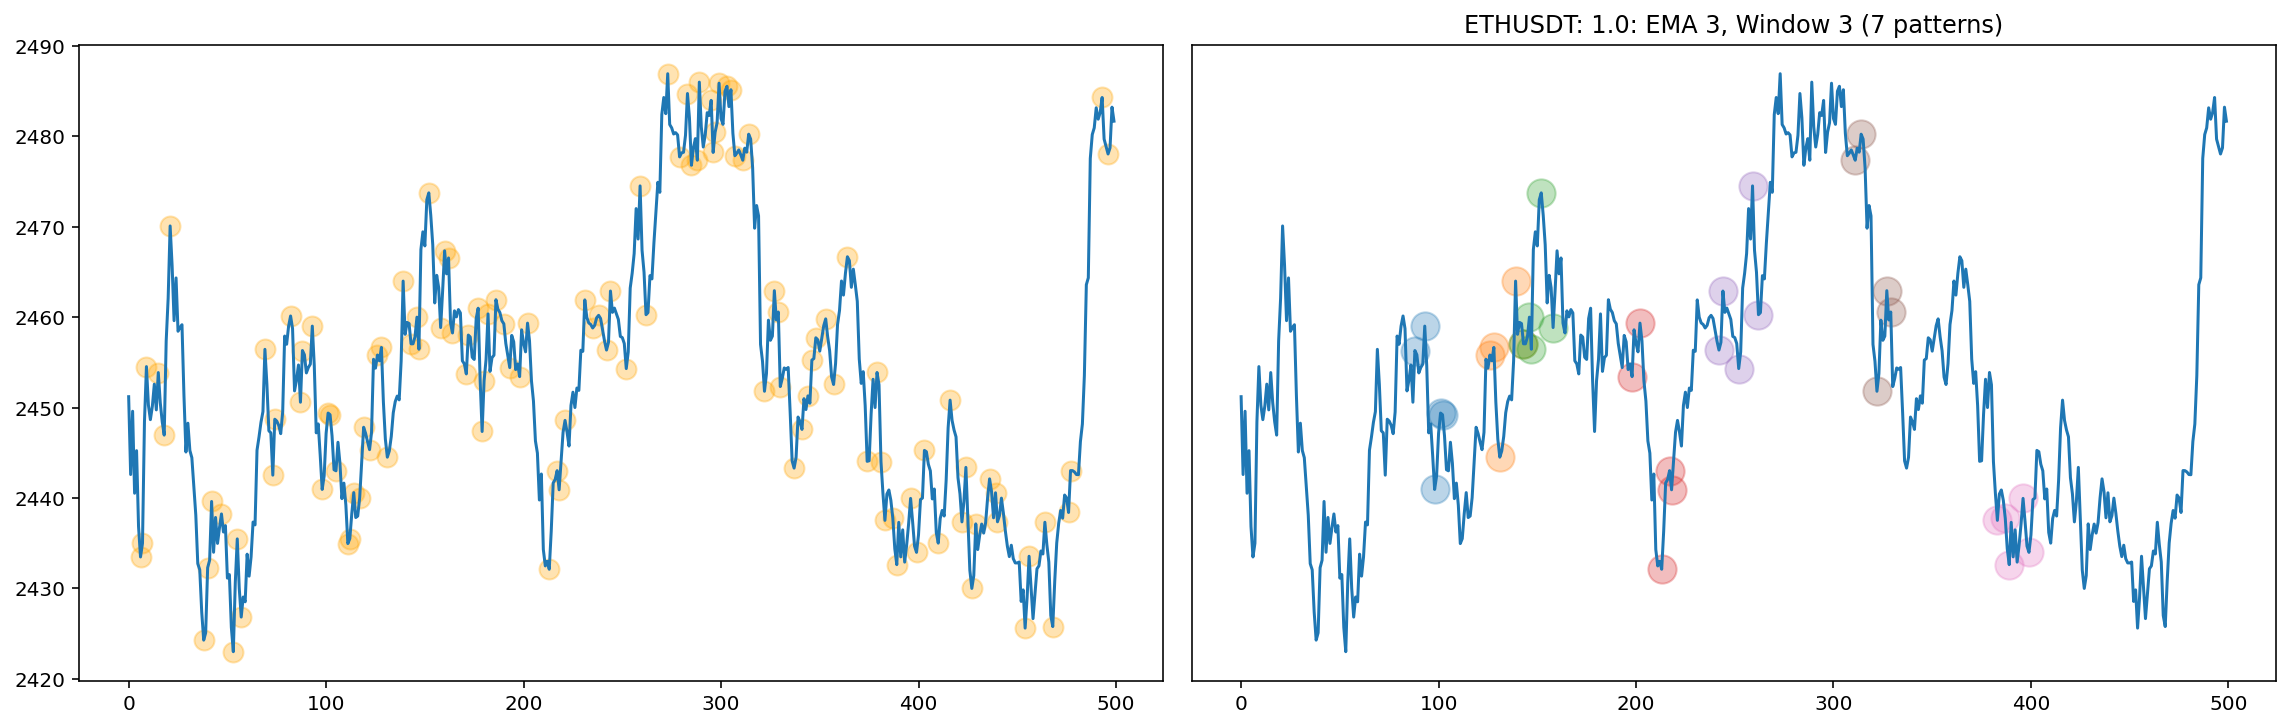

In [43]:
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['c']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))
plot_minmax_patterns(resampled_prices, min_max, patterns, stock, 3, 3)